In [1]:
import sklearn.datasets as datasets
import sklearn.metrics as metrics
import sklearn.decomposition as decomposition
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import pandas as pd

import mlgrad.af as af
import mlgrad.funcs as funcs
import mlgrad.funcs2 as funcs2
import mlgrad.models as models
import mlgrad.loss as loss
import mlgrad.boost.robanyboost as robanyboost
import mlgrad.boost.anyboost as anyboost
import mlgrad.inventory as inventory
import mlgrad.plots as plots

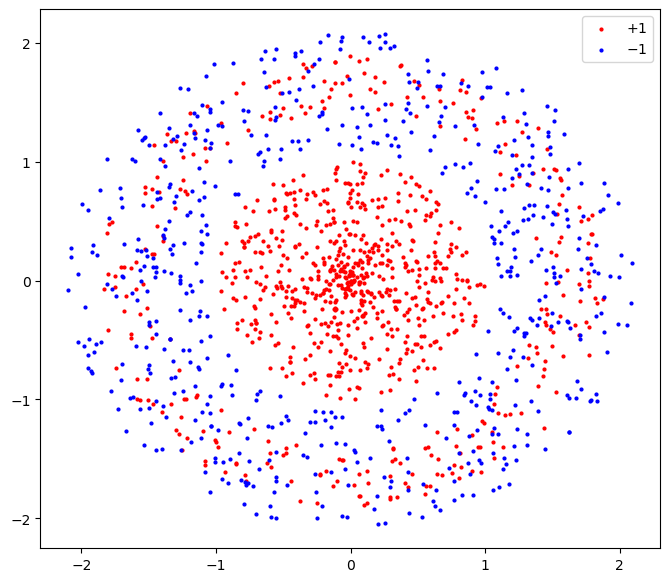

(1500, 2) (1500,)
0.8


In [2]:

N1 = 600
A1 = np.random.random(N1)
R1 = np.random.random(N1)**0.8
X1 = np.c_[R1*np.cos(2*np.pi*A1), R1*np.sin(2*np.pi*A1)]

A2 = np.random.random(N1)
R2 = 1.1+np.random.random(N1)
X2 = np.c_[R2*np.cos(2*np.pi*A2), R2*np.sin(2*np.pi*A2)]

N2 = 300
A3 = np.random.random(N2)
R3 = 1.4+0.5*np.random.random(N2)**0.8
X3 = np.c_[R3*np.cos(2*np.pi*A3), R3*np.sin(2*np.pi*A3)]

A4 = np.random.random(N2)
R4 = 1.1+np.random.random(N2)
X4 = np.c_[R4*np.cos(2*np.pi*A4), R4*np.sin(2*np.pi*A4)]

X = np.vstack((X1,X2,X3)) #,X4))
Y = np.hstack([np.ones(N1, "d"), -np.ones(N1, "d"), np.ones(N2, "d")]) #, -np.ones(N2, "d")])
# YY = np.hstack([np.ones(N, "d"), -np.ones(N, "d")])

N = len(Y)

XX1 = np.vstack((X1,X3)) 
XX2 = np.vstack((X2,)) 
# XX = np.vstack((X1,X2)) 

plt.figure(figsize=(8,7))
plt.scatter(XX1[:,0], XX1[:,1], c="r", s=4, label="$+1$")
plt.scatter(XX2[:,0], XX2[:,1], c="b", s=4, label="$-1$")
plt.legend()
plt.show()

print(X.shape, Y.shape)
alpha = (2*N1)/(2*N1+N2)
print(alpha)

In [3]:
softhinge_func = funcs.SoftHinge_Exp(1.0)
def sigmoidal_factory(n):
    return models.SigmaNeuronModel(funcs.Sigmoidal(4.0), n)

In [4]:
shrink = 0.01
n_classifier = 300

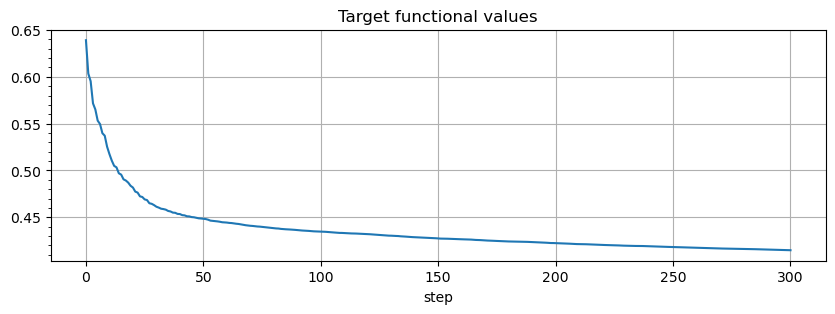

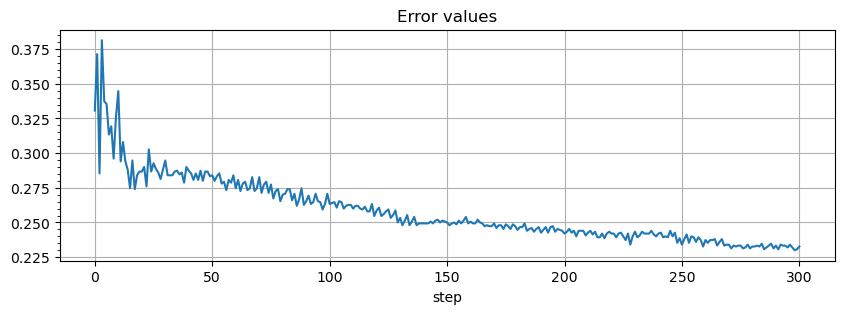

In [5]:
# cls = anyboost.AnyBoostClassification(
#     func=softhinge_func,
#     model_factory=sigmoidal_factory, 
#     shrink=shrink,
#     # min_weak_learn_score=0.01,
#     n_classifier=n_classifier)
# cls.fit(X, Y)

cls = robanyboost.RobustAnyBoostClassification(
    aggfunc=af.averaging_function("AM"),
    func=softhinge_func, 
    model_factory=sigmoidal_factory, 
    shrink=shrink,
    # min_weak_learn_score=0.01,
    n_classifier=n_classifier)
cls.fit(X, Y)

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

plt.figure(figsize=(10,3))
plt.title("Error values")
plt.plot(cls.errvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()


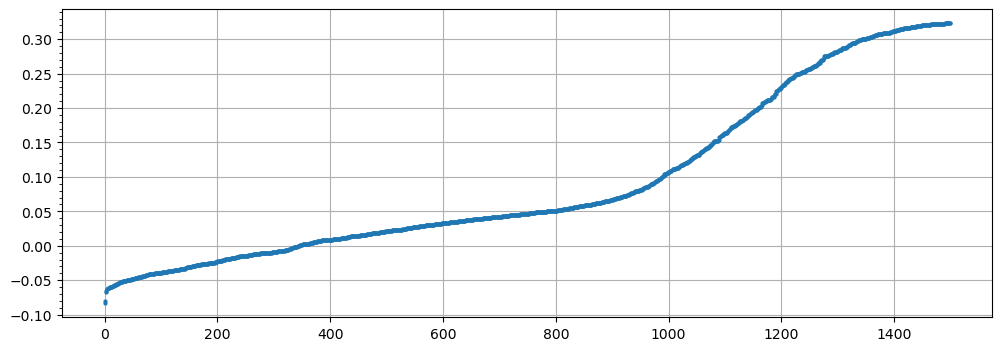

In [6]:
M = Y*cls.H.evaluate(X)
Z = inventory.modified_zscore(M)
# Z = inventory.zscore(M)

plt.figure(figsize=(12,4))
# plt.title("Classifier scores")
plt.plot(sorted(M), marker='o', markersize=2, linewidth=0)
# plt.plot(sorted(Z), marker='o', markersize=2, linewidth=0)
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

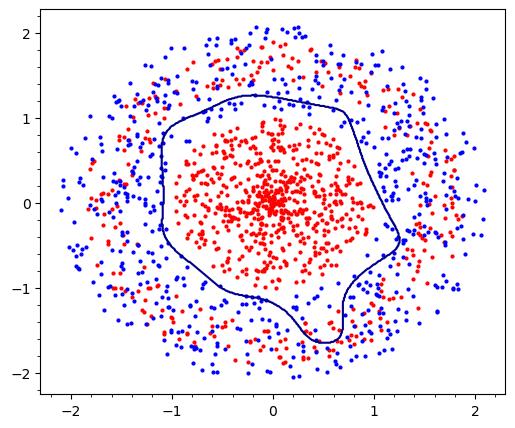

In [7]:
XX, YY = np.meshgrid(np.linspace(-2.0, 2.0, 400), np.linspace(-2.0, 2.0, 400))
XY = np.c_[XX.ravel(), YY.ravel()]

plt.figure(figsize=(6,5))
ZZ = np.sign(cls.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
# plt.scatter(X[:,0], X[:,1], c=Y, edgecolors='k')
plt.scatter(XX1[:,0], XX1[:,1], c="r", s=4, label="+1")
plt.scatter(XX2[:,0], XX2[:,1], c="b", s=4, label="-1")

plt.contour(ZZ, extent=(-2.0, 2.0, -2.0, 2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.show()

0.8


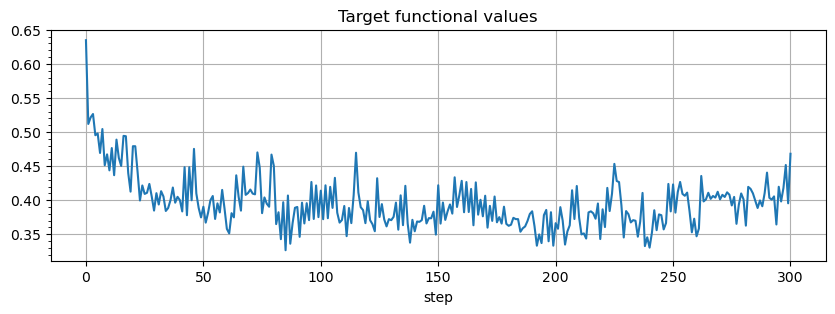

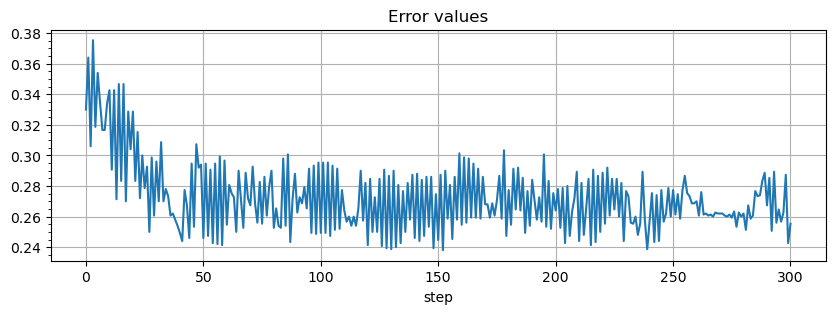

In [8]:
# alpha = (Z >= -1).astype("i").sum() / N
# if alpha == 1:
#     alpha = 0.999
print(alpha)


cls2 = robanyboost.RobustAnyBoostClassification(
    aggfunc=af.averaging_function("WM", funcs.QuantileFunc(0.80, funcs.SoftAbs_Sqrt(0.01))),
    func=softhinge_func, 
    model_factory=sigmoidal_factory, 
    shrink=shrink,
    # min_weak_learn_score=0.01,
    n_classifier=n_classifier)
cls2.fit(X, Y)

plt.figure(figsize=(10,3))
plt.title("Target functional values")
plt.plot(cls2.lvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()

plt.figure(figsize=(10,3))
plt.title("Error values")
plt.plot(cls2.errvals)
plt.xlabel("step")
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.show()


In [9]:
accuracy = metrics.accuracy_score(np.sign(cls.H.evaluate(X)),Y)
accuracy2 = metrics.accuracy_score(np.sign(cls2.H.evaluate(X)),Y)
print(accuracy, accuracy2)

0.77 0.762


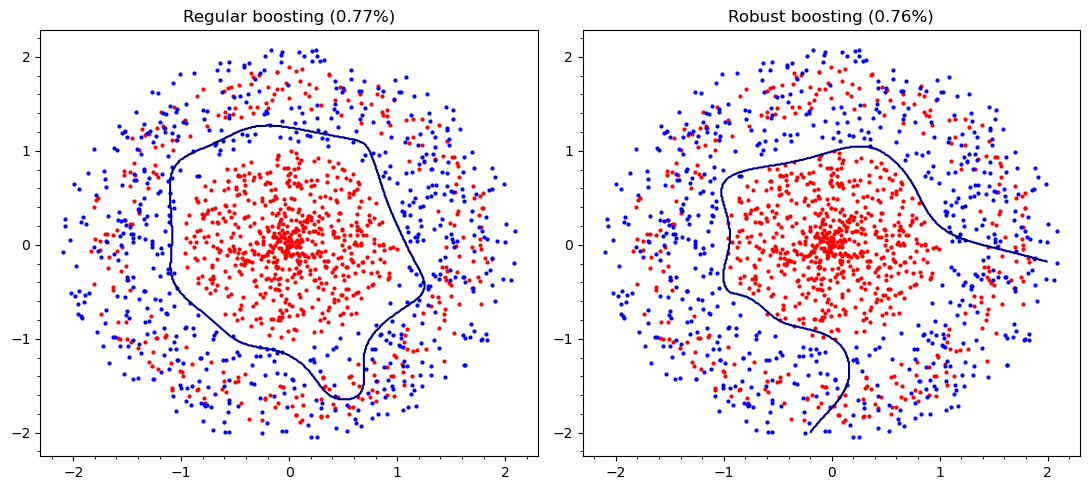

In [10]:
XX, YY = np.meshgrid(np.linspace(-2.0, 2.0, 400), np.linspace(-2.0, 2.0, 400))
XY = np.c_[XX.ravel(), YY.ravel()]

plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.title(f"Regular boosting ({accuracy:.2f}%)")
ZZ = np.sign(cls.H.evaluate(XY))
ZZ = ZZ.reshape(XX.shape)
plt.scatter(XX1[:,0], XX1[:,1], c="r", s=4, label="+1")
plt.scatter(XX2[:,0], XX2[:,1], c="b", s=4, label="-1")
plt.contour(ZZ, extent=(-2.0, 2.0, -2.0, 2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.subplot(1,2,2)
plt.title(f"Robust boosting ({accuracy2:.2f}%)")
ZZ2 = np.sign(cls2.H.evaluate(XY))
ZZ2 = ZZ2.reshape(XX.shape)
plt.scatter(XX1[:,0], XX1[:,1], c="r", s=4, label="+1")
plt.scatter(XX2[:,0], XX2[:,1], c="b", s=4, label="-1")
plt.contour(ZZ2, extent=(-2.0, 2.0, -2.0, 2.0), levels=[0], colors=["darkblue"])
plt.minorticks_on()
plt.savefig("fig/robanyboost_1.eps")
plt.tight_layout()
plt.show()

In [11]:
# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.title(f"Anyboost (accuracy={accuracy:.3f})")
# plt.scatter(range(N), cls.H.evaluate(X), c=Y)
# plt.hlines(0, 0, N, color='k', linestyles='--', linewidths=1.0)
# # plt.ylim(-0.15,0.15)
# plt.subplot(1,2,2)
# plt.title(f"Robust Anyboost (accuracy={accuracy2:.3f})")
# plt.scatter(range(N), cls2.H.evaluate(X), c=Y)
# plt.hlines(0, 0, N, color='k', linestyles='--', linewidths=1.0)
# # plt.ylim(-0.15,0.15)
# plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


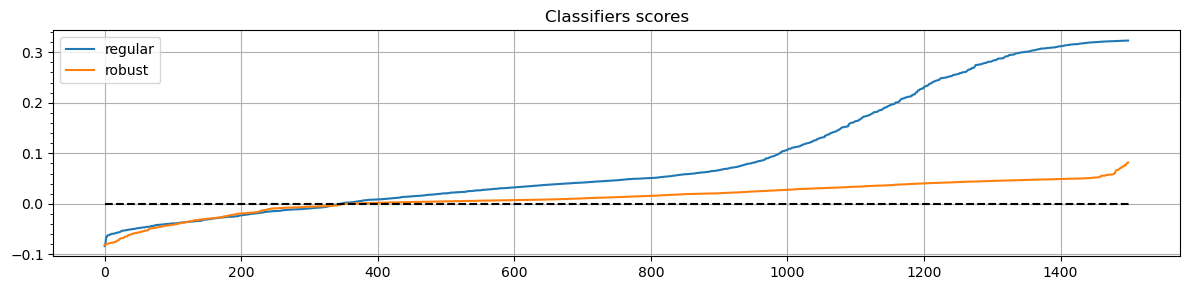

In [12]:
M2 = Y*cls2.H.evaluate(X)
Z2 = inventory.modified_zscore(M2)

plt.figure(figsize=(12,3))
plt.title("Classifiers scores")
plt.plot(sorted(M), label='regular')
plt.plot(sorted(M2), label='robust')
ax = plt.gca()
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
plt.grid(1)
plt.legend()
plt.hlines(0, 0, N, colors='k', linestyles='--')
plt.savefig("fig/robanyboost_2.eps")
plt.tight_layout()
plt.show()

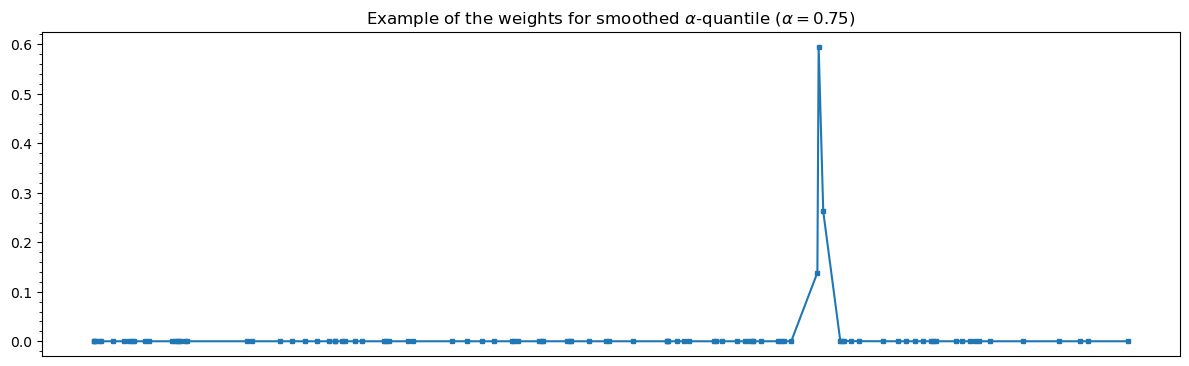

In [13]:
V = np.random.random(100)
V.sort()
aggfunc=af.averaging_function("M", funcs.QuantileFunc(0.75, funcs.SoftAbs_Sqrt(0.001)))

plt.figure(figsize=(12,4))
plt.title(r"Example of the weights for smoothed $\alpha$-quantile ($\alpha=0.75$)")
plt.plot(V, aggfunc.gradient(V), marker='s', markersize=3)
plt.savefig("fig/quantile_weights.eps")
plt.tight_layout()
plt.minorticks_on()
plt.xticks([])
plt.show()

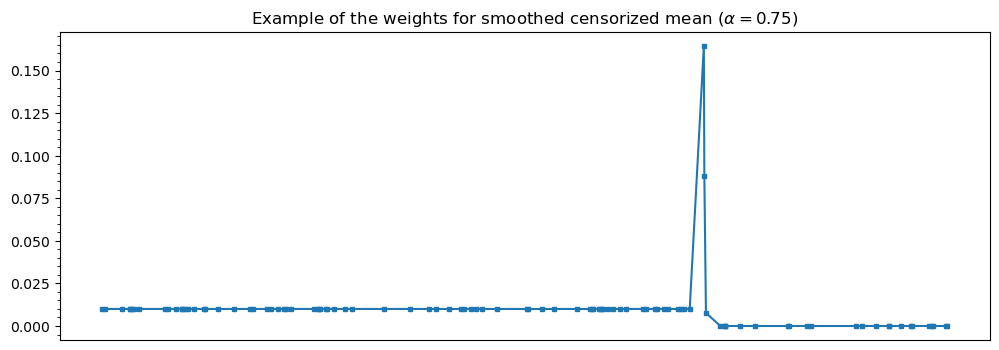

In [14]:
V = np.random.random(100)
V.sort()
aggfunc=af.averaging_function("WM", funcs.QuantileFunc(0.75, funcs.SoftAbs_Sqrt(0.001)))

plt.figure(figsize=(12,4))
plt.title(r"Example of the weights for smoothed censorized mean ($\alpha=0.75$)")
plt.plot(V, aggfunc.gradient(V), marker='s', markersize=3)
plt.savefig("fig/cp_weights.eps")
plt.minorticks_on()
plt.xticks([])
plt.show()

In [15]:
import scipy.optimize as opt